**Simple Lens Modelling**

In this notebook we will try to fit some models to quasar lenses.

Fist step is to define a class that will return the $\chi^2$ that is to be minimized.  The constructor will take a lens object which can be changed and the observed image and lens positions.  

This version does source plane optimization.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = [10,10]
from scipy.optimize import minimize,fsolve,brentq

import astropy.cosmology as cosmo

    
class CHI_SQUARED_SOURCE :
    
    def __init__(self,lens,x_images):
        self.lens = lens
        self.x = x_images
        self.n_images = len(x_images)
        self.y=np.zeros((self.n_images,2))

    def __call__(self,p) :
        
        self.lens.reset(p)
        self.y[0] = self.x[0]-self.lens.alpha(self.x[0])
        sig = np.sign(self.lens.mu(self.x[0]))
        for i in range(1,self.n_images) :
            self.y[i] = self.x[i]-self.lens.alpha(self.x[i])
            sig += np.sign(self.lens.lambda_r(self.x[i])*self.lens.lambda_t(self.x[i]))
    
        return np.sum((self.y-self.y[0])**2) + 100 * abs(sig) * np.sum((self.y-self.lens.xo)**2)
    
    # this is used to make a plot of the results
    def plot(self,result,title='') :
        
        self.lens.reset(result.x)
       
        fig1, ax = plt.subplots()
        ax.set_box_aspect(1)

        ax.scatter(self.x[:,0],self.x[:,1],label='observed image positions')
        ax.scatter(self.lens.xo[0],self.lens.xo[1],label='ob. lens positions',s=6)


        y = np.empty_like(self.x)
        center = np.zeros(2)
        for i in range(0,len(self.x)) :
             y[i] = self.x[i]-self.lens.alpha(self.x[i])
             ax.scatter(y[i,0],y[i,1],label='source positions '+str(i),s=3.)
             
             center += self.x[i]

        center = center/len(self.x)
        boxsize = 1.5*(np.max(self.x) - np.min(self.x))
        
        plt.xlim(center[0]-boxsize/2,center[0]+boxsize/2)
        plt.ylim(center[1]-boxsize/2,center[1]+boxsize/2)
        
        # If the lens.xt() function exists, plot the tangential
        # critical curve and caustic
        if hasattr(self.lens,'xt') :
            xt = self.lens.xt()
            ax.plot(xt[0,:],xt[1,:],linestyle='--',label='tang. crit.')
                
            yt = np.empty_like(xt)
            for i in range(0,len(yt[0,:])) : 
                yt[:,i] = xt[:,i] - self.lens.alpha(xt[:,i]) 
                   
            ax.plot(yt[0,:],yt[1,:],label='tang. caustic',linewidth=0.5)
            
        if hasattr(self.lens,'xr') :
            xr = self.lens.xr()
            ax.plot(xr[0,:],xr[1,:],linestyle='--',label='radial crit.')
          
            yr = np.empty_like(xr)
            for i in range(0,len(yt[0,:])) : 
                yr[:,i] = xr[:,i] - self.lens.alpha(xr[:,i]) 
             
            ax.plot(yr[0,:],yr[1,:],label='radial caustic',linewidth=0.5)

        plt.legend()
        plt.title(title)
        plt.show()


1) Now we need to make a lens model class.  Let's start with one for a singular isothermal sphere (SIS).  

The lens class must have the functions alpha(), kappa(), reset(), mu() and number_of_params().  The reset() function is used to reset the internal parameters.  In this case there is one parameter, the Einstein radius, which we will call $b$. xo is the coordinates of the center of the lens.

In [34]:
class sis_lens:
    
    def __init__(self,xo,b):
        self.xo = xo
        self.b = b
        
    def alpha(self,x) :
        dx = x - self.xo
        r = np.sqrt(dx[0]*dx[0] + dx[1]*dx[1])
        return self.b*dx/r

    def kappa(self,x) :
        dx = x - self.xo
        r = np.sqrt(dx[0]*dx[0] + dx[1]*dx[1])
        return self.b/r
    
    def reset(self,p) :
        self.b = p[0]

    def resetXo(self,xo) :
        self.xo = xo
        
    def number_of_params(self) :
        return 1
    
    # radial eigenvalue
    def lambda_r(self,x) :
        return 1

    # tangential eigenvalue
    def lambda_t(self,x) :
        dx = x - self.xo
        r = np.sqrt(dx[0]*dx[0] + dx[1]*dx[1])
        return 1-self.b/r
    
    # magnification
    def mu(self,x) :
        return 1.0/self.lambda_t(x)

    # points on the tangential critical curve
    def xt(self) :
       theta = np.arange(0,2*np.pi,0.01)
       x = np.empty([2,len(theta)])
       x[0] = self.b*np.cos(theta) + self.xo[0]
       x[1] = self.b*np.sin(theta) + self.xo[1]
       
       return x


2) Now we need some data.  The CASTLES Survey 
[website](https://lweb.cfa.harvard.edu/castles/) has the positions, fluxes and images for many QSO lenses that have been observed with HST.  From there you can copy the image and lens positions.

Let us start with double quasar Q0142-100.

SIS result for Q0142-100
      fun: 0.024389830869870458
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.01227924e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([1.11901524])


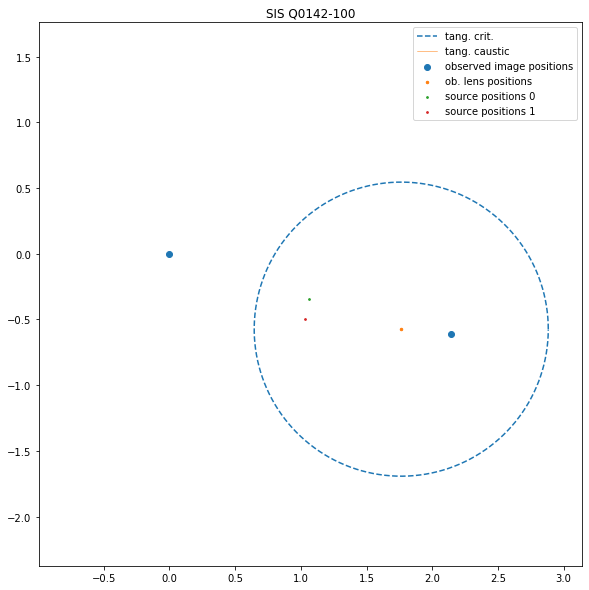

In [35]:
# Q0142-100
x_0142 =  np.array([[0,0],[2.145,-0.613]]) # image positions
xo_0142 = np.array([1.764,-0.574]) # lens galaxy position

# Make a SIS lens.  The initial parameters 
# are not important
sis = sis_lens(xo_0142,1)

# Set the initial consditions for the parameters,
# only one in this case.
po =np.array([1.2])  

# create the chi2 object
chi2 = CHI_SQUARED_SOURCE(sis,x_0142)
# Find the solution by minimizing the chi squared.
# The bounds gives the allowed range of the parameters
result_sis = minimize(chi2,po,bounds=[[0,2]])
# print the results
print("SIS result for Q0142-100")
print(result_sis)

# make a plot
chi2.plot(result_sis,title='SIS Q0142-100')

Maybe we need a more flexible model.  Here is a non-singular isothermal (NSIS) model.  It as two parameters, the Einstein radius and the core radius.

In [ ]:
class nsis_lens:
    
    def __init__(self,xo,b,xc):
        self.xo = xo
        self.b = b
        self.xc = xc
        
    def alpha(self,x) :
        dx = x - self.xo
        r = np.sqrt(dx[0]*dx[0] + dx[1]*dx[1])
        return self.b* dx / r * (np.sqrt( 1+ self.xc * self.xc/r/r) - self.xc/r)

    def kappa(self,x) :
        dx = x - self.xo
        r = np.sqrt(dx[0]*dx[0] + dx[1]*dx[1] + self.xc*self.xc)
        return self.b/r
    
    def reset(self,p) :
        self.b = p[0]
        self.xc = p[1]

    def resetXo(self,xo) :
        self.xo = xo

    def number_of_params(self) :
       return 2

    def lambda_r(self,x) :
        dx = x - self.xo
        r = np.sqrt(dx[0]*dx[0] + dx[1]*dx[1])
        return 1 + self.b*( (np.sqrt(r*r + self.xc*self.xc) - self.xc)/r/r - 1.0/np.sqrt(r*r + self.xc*self.xc) )

    def lambda_t(self,x) :
        dx = x - self.xo
        r = np.sqrt(dx[0]*dx[0] + dx[1]*dx[1])
        return 1 - self.b*(np.sqrt(r*r + self.xc*self.xc) - self.xc)/r/r
    
    def mu(self,x) :
        return 1.0/self.lambda_t(x)/self.lambda_r(x)

    def xt(self) :
        
        def func(r):
            return 1 - self.b*(np.sqrt(r*r + self.xc*self.xc) - self.xc)/r/r
        rt = fsolve(func,self.b)
        
        theta = np.arange(0,2*np.pi,0.01)
        x = np.empty([2,len(theta)])
        x[0] = rt * np.cos(theta) + self.xo[0]
        x[1] = rt * np.sin(theta) + self.xo[1]
        
        return x
    
    def xr(self) :
        
        def func(r):
            return 1 + self.b*( (np.sqrt(r*r + self.xc*self.xc) - self.xc)/r/r - 1.0/np.sqrt(r*r + self.xc*self.xc) )
        rc = fsolve(func,self.b)
        
        theta = np.arange(0,2*np.pi,0.01)
        x = np.empty([2,len(theta)])
        x[0] = rc * np.cos(theta) + self.xo[0]
        x[1] = rc * np.sin(theta) + self.xo[1]
        
        return x

4) Run this NSIS model on Q0142-100 and see if we get something better.

NSIS result for Q0142-100
      fun: 0.013374710116397001
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02497685, -0.002241  ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 390
      nit: 10
     njev: 130
   status: 0
  success: True
        x: array([1.43640891, 0.17436675])


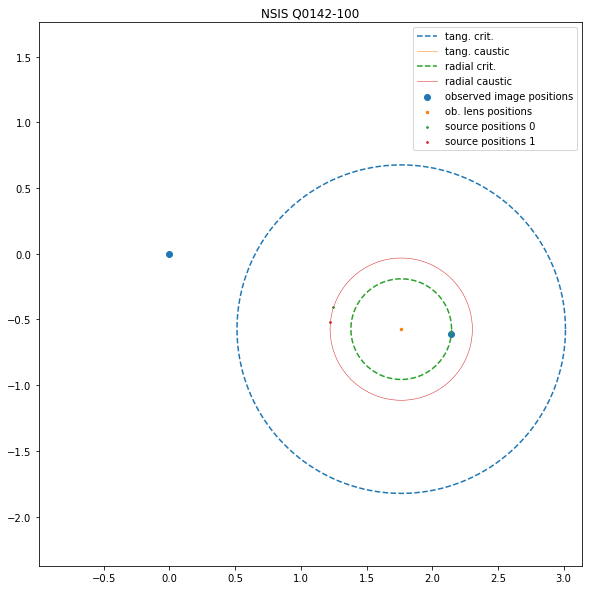

In [38]:

nsis = nsis_lens(xo_0142,1,0)
po =np.array([1.119,0])  

# create the chi2 object
chi2 = CHI_SQUARED_SOURCE(nsis,x_0142)
result_nsis = minimize(chi2,po,bounds=[[0,2],[0,0.5]])
# print the results
print("NSIS result for Q0142-100")
print(result_nsis)

# make a plot
chi2.plot(result_nsis,title='NSIS Q0142-100')

We will never get more than three images with and axially symmetric model.  You can see that many of the lenses in the CASTLES data base have 4 images.  To fit them we will make a Singular Isothermal Ellipsoid (SIE) model class.

In [39]:
class sie_lens:
    
    def __init__(self,xo,b,f,phi):
        self.xo = xo
        self.b = b
        self.f = f
        self.phi = phi
        self.fp = np.sqrt(1-f*f)
    
    def rotate(self,x,phi) :
        tmp = x[0]
        x[0] = x[0]*np.cos(phi) - x[1]*np.sin(phi)
        x[1] = x[1]*np.cos(phi) + tmp*np.sin(phi)
    
    def alpha(self,x) :
        dx = x - self.xo
        self.rotate(dx,-self.phi)
        
        r = np.sqrt(dx[0]*dx[0] + dx[1]*dx[1])
        a = np.array([np.arcsinh(self.fp*dx[0]/r/self.f),np.arcsin(self.fp*dx[1]/r)]) * np.sqrt(self.f)/self.fp
        
        self.rotate(a,self.phi)
        
        return self.b*a

    def kappa(self,x) :
        dx = x - self.xo
        r = np.sqrt(dx[0]*dx[0] + self.f*self.f*dx[1]*dx[1])
        
        return 0.5*self.b*np.sqrt(self.f)/r
    
    def reset(self,p) :
        self.b = p[0]
        self.f = p[1]
        self.fp = np.sqrt(1-p[1]*p[1])
        self.phi = p[2]
        
    def resetXo(self,xo) :
        self.xo = xo
        
    def number_of_params(self) :
        return 3
    
    def lambda_r(self,x) :
        return 1
    
    def lambda_t(self,x) :
        return 1-2*self.kappa(x)

    def mu(self,x) :
        return 1.0/self.lambda_t(x)

    def xt(self) :
        theta = np.arange(0,2*np.pi,0.01)
        x = np.empty([2,len(theta)])
        delta = np.sqrt(np.cos(theta - self.phi)**2 + (self.f*np.sin(theta - self.phi))**2)
        x[0] = self.b*np.sqrt(self.f)*np.cos(theta) / delta + self.xo[0]
        x[1] = self.b*np.sqrt(self.f)*np.sin(theta) / delta + self.xo[1]
        
        return x
 
    def images(self,yy1,yy2,verbose=False):
       
        y = np.array([yy1 - self.xo[0],yy2 - self.xo[1]])
        self.rotate(y,-self.phi)
        
        def phi_func(phi):
            a1=self.b*np.sqrt(self.f)/self.fp*np.arcsinh(self.fp/self.f*np.cos(phi))
            a2=self.b*np.sqrt(self.f)/self.fp*np.arcsin(self.fp*np.sin(phi))
            return (y[0]+a1)*np.sin(phi)-(y[1]+a2)*np.cos(phi)

        U=np.linspace(0.,2.0*np.pi+0.001,100)
        c = phi_func(U)
        s = np.sign(c)
        phi=[]
        xphi=[]
        imag=[]
        
        for i in range(100-1):
            if s[i] + s[i+1] == 0: # opposite signs
                u = brentq(phi_func, U[i], U[i+1])
                z = phi_func(u) ## angle of a possible image 
                if np.isnan(z) or abs(z) > 1e-3:
                    continue
                x = y[0]*np.cos(u)+y[1]*np.sin(u)+self.b*np.sqrt(self.f)/self.fp*(np.sin(u)*np.arcsin(self.fp*np.sin(u)) + np.cos(u)*np.arcsinh(self.fp/self.f*np.cos(u)))
                if (x>0):
                    phi.append(u)
                    xphi.append(x)
                    t = x*np.array([np.cos(u),np.sin(u)])
                    self.rotate(t,self.phi)
                    imag.append(t + self.xo)
                if (verbose):
                    print('found zero at {}'.format(u))
                    if (x<0):
                        print ('discarded because x is negative ({})'.format(x))
                    else:
                        print ('accepted because x is positive ({})'.format(x))
                        
        return imag

5) Try fitting this to Q0142-100.

SIE result for Q0142-100 SIE
      fun: 0.02532644499120429
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.55535308e-06, -9.46226957e-02,  4.27641741e-03])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 28
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([1.11716654, 0.99      , 0.        ])


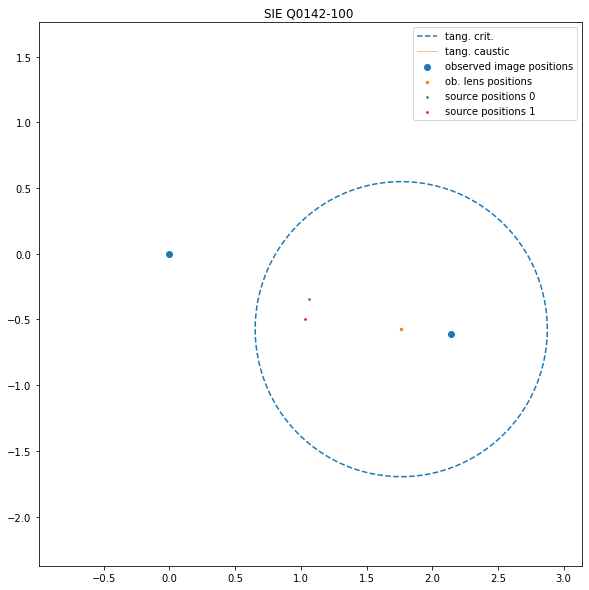

In [40]:
sie = sie_lens(xo_0142,1,0.999,0)
po =np.array([1.119,0.9,0])  

# create the chi2 object
chi2 = CHI_SQUARED_SOURCE(sie,x_0142)
result_sie = minimize(chi2,po,bounds=[[0,2],[0.2,0.99],[0,np.pi]])
# print the results
print("SIE result for Q0142-100 SIE")
print(result_sie)

# make a plot
chi2.plot(result_sie,title='SIE Q0142-100 ')

6) Go to the CASTLES site and find the data for quad lens HE0435-1223 site.  Enter the data as above and fit this lens with a SIE model.  You can also try Q2237.

SIE result for Q0435-1223 SIE
      fun: 0.0006170923001568289
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.30920666e-06,  3.17389342e-07, -1.01565891e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 64
      nit: 9
     njev: 16
   status: 0
  success: True
        x: array([1.22035667, 0.65752727, 0.24923571])


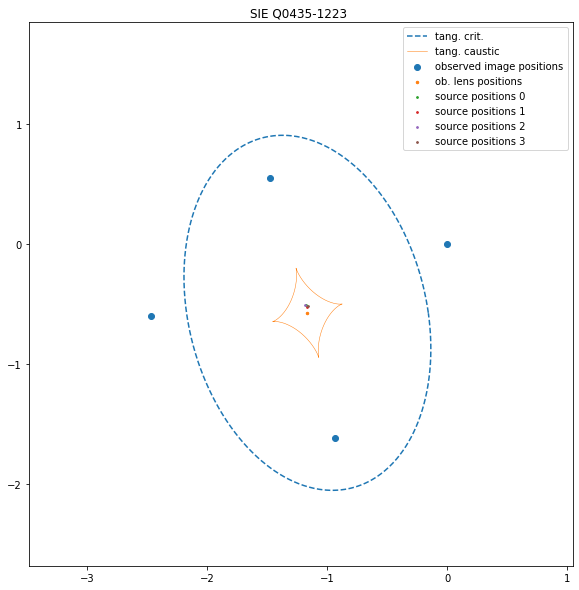

In [44]:
x_0435 =  np.array([[0,0],[-1.476,0.552],[-2.467,-0.603],[-0.939,-1.614]])
xo_0435 = np.array([-1.165,-0.573])

sie = sie_lens(xo_0435,1,0.999,0)
po =np.array([1.119,0.9,0])  

# create the chi2 object
chi2 = CHI_SQUARED_SOURCE(sie,x_0435)
result_sie = minimize(chi2,po,bounds=[[0,2],[0.2,0.99],[0,np.pi]])
# print the results
print("SIE result for Q0435-1223 SIE")
print(result_sie)

# make a plot
chi2.plot(result_sie,title='SIE Q0435-1223 ')

7) Calculate the physical size of the Einstein radius for HE0435-1223.  You can use the astropy.cosmology package to calculate the distances.  Calculate the critical density for this lens and mass within the Einstein radius.

In [ ]:
# these might be useful
from astropy import constants as const 
from astropy import units as u

# Einstein radius in radius
# Einstein radius in kpc
# Critical density in Msolar / kpc**2
# mass within the Einstein radius

8) Let us look at RXJ1131-1231.  Can you get a good model for it?

SIE result for Q1131-1231 SIE
      fun: 164.68423201499104
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.70530258e-05, -5.96855895e-05, -1.70530258e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 176
      nit: 23
     njev: 44
   status: 0
  success: True
        x: array([1.94051061, 0.85186152, 1.39031857])


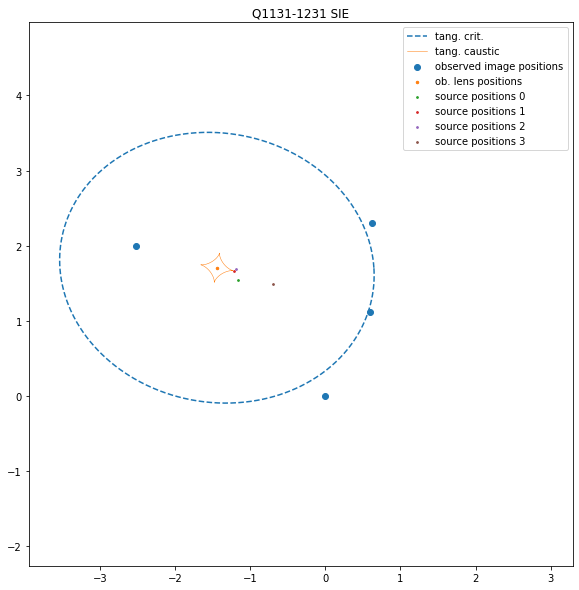

In [45]:
x_1131 =  np.array([[0,0],[0.588,1.120],[0.618,2.307],[-2.517,1.998]])
xo_1131 = np.array([-1.444,1.706])


sie = sie_lens(xo_1131,1,0.999,0)
po =np.array([1.119,0.9,0])  

# create the chi2 object
chi2 = CHI_SQUARED_SOURCE(sie,x_1131)
result_sie = minimize(chi2,po,bounds=[[0,2],[0.2,0.99],[0,np.pi]])
# print the results
print("SIE result for Q1131-1231 SIE")
print(result_sie)

# make a plot
chi2.plot(result_sie,title='Q1131-1231 SIE')

So far we have used source plane optimization.  Here is a different version of the CHI_SQUARED object to do image plane optimization.  The biggest difference is in the __call__ function.

In [ ]:
class CHI_SQUARED_IMAGE :
    
    def __init__(self,lens,x_images):
        self.lens = lens
        self.x = x_images
        self.n_images = len(x_images)
        self.y=np.zeros((self.n_images,2))

    def __call__(self,p) :
        
        self.lens.reset(p)
        
        y = self.x[0]-self.lens.alpha(self.x[0])
        for i in range(1,self.n_images) :
            y += self.x[i]-self.lens.alpha(self.x[i])
            
        y = y/self.n_images
        
        x_images = np.array(self.lens.images(y[0],y[1]))
               
        n_images = len(x_images)
        
        # find parities of the images
        parity_ob = np.empty(self.n_images)
        for i in range(0,self.n_images) :
            parity_ob[i] = np.sign(self.lens.mu(self.x[i]))
        
        parity_mod = np.empty(n_images)
        for i in range(0,n_images) :
            parity_mod[i] = np.sign(self.lens.mu(x_images[i]))
        
        chi2_test = 0
        matrix = np.zeros([n_images,self.n_images])
        for j in range(0,n_images) :
            dchi2 = 1.0e100
            for i in range(0,self.n_images) :
                
                matrix[j,i] = np.sum( (x_images[j]-self.x[i])**2 )
                if(parity_ob[i] == parity_mod[j]) :
                    tmp = matrix[j,i]
                    if(tmp < dchi2 ) :
                        dchi2 = tmp
                        
            chi2_test += dchi2
        
        chi2 = 0
        for j in range(0,n_images) :
            chi2 += np.min(matrix[j,:])
 
        for j in range(n_images,self.n_images) :
            chi2 += np.max(matrix)
            
        return chi2
    
    def plot(self,result,title='') :
        
        self.lens.reset(result.x)
       
        fig1, ax = plt.subplots()
        ax.set_box_aspect(1)

        ax.scatter(self.x[:,0],self.x[:,1],label='observed image positions')
        ax.scatter(self.lens.xo[0],self.lens.xo[1],label='ob. lens positions',s=6)

        y = self.x[0]-self.lens.alpha(self.x[0])
        for i in range(1,self.n_images) :
            y += self.x[i]-self.lens.alpha(self.x[i])
    
        y = y/self.n_images

        x_images = np.array(self.lens.images(y[0],y[1]))

        ax.scatter(x_images[:,0],x_images[:,1],label='model image positions')
        ax.plot(y[0],y[1],'x',label='model source position')
        
        center = np.zeros(2)
        for i in range(0,len(x)) :  
             center += self.x[i]

        center = center/len(self.x)
        boxsize = 1.5*(np.max(self.x) - np.min(self.x))
        
        plt.xlim(center[0]-boxsize/2,center[0]+boxsize/2)
        plt.ylim(center[1]-boxsize/2,center[1]+boxsize/2)
        
        if hasattr(self.lens,'xt') :
            xt = self.lens.xt()
            ax.plot(xt[0,:],xt[1,:],linestyle='--',label='tang. crit.')
                
            yt = np.empty_like(xt)
            for i in range(0,len(yt[0,:])) : 
                yt[:,i] = xt[:,i] - self.lens.alpha(xt[:,i]) 
                   
            ax.plot(yt[0,:],yt[1,:],label='tang. caustic',linewidth=0.5)
            
        if hasattr(self.lens,'xr') :
            xr = self.lens.xr()
            ax.plot(xr[0,:],xr[1,:],linestyle='--',label='radial crit.')
          
            yr = np.empty_like(xr)
            for i in range(0,len(yt[0,:])) : 
                yr[:,i] = xr[:,i] - self.lens.alpha(xr[:,i]) 
             
            ax.plot(yr[0,:],yr[1,:],label='radial caustic',linewidth=0.5)

        plt.legend()
        plt.title(title)
        plt.show()

9) Try fitting RXJ1131-1231 to an SIE with this chi2.  It might help to use the results of the previous fit as a starting point for this one.

Try fitting some of the other lenses.

SIE result for Q0435-1223 SIE
      fun: 0.0017776122287735618
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.82287174e-08,  1.39528145e-06, -1.77581474e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 72
      nit: 13
     njev: 18
   status: 0
  success: True
        x: array([1.21566776, 0.68420199, 0.24327587])


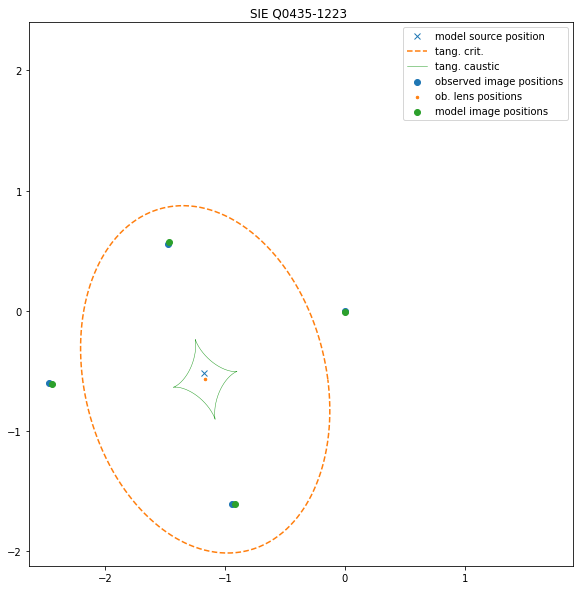

In [46]:

sie = sie_lens(xo_0435,1,0.999,0)
po =np.array([1.119,0.9,0])  

# create the chi2 object
chi2 = CHI_SQUARED_IMAGE(sie,x_0435)
result_sie = minimize(chi2,po,bounds=[[0,2],[0.2,0.99],[0,np.pi]])
# print the results
print("SIE result for Q0435-1223 SIE")
print(result_sie)

# make a plot
chi2.plot(result_sie,title='SIE Q0435-1223 ')